In [65]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [66]:
tf.__version__

'2.15.0'

In [176]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)


train_dataset = tf.keras.utils.image_dataset_from_directory("dataset/skin-lesions/train",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory("dataset/skin-lesions/test",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory("rsults/skin_lesion",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 15004 files belonging to 3 classes.


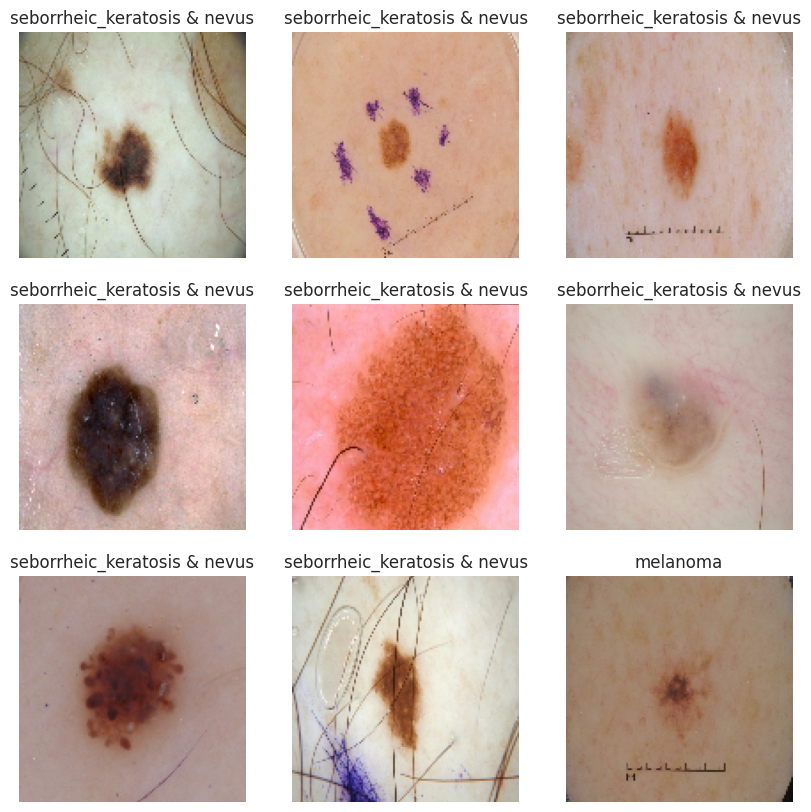

In [177]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [179]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [180]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(),
  # tf.keras.layers.RandomFlip('vertical'),
  # tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  # tf.keras.layers.RandomTranslation(0.2, 0.2),
  # tf.keras.layers.RandomBrightness(0.2),
])

In [181]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [182]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB7(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [183]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 2560)


In [184]:
base_model.trainable = True

In [185]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  814


In [186]:
fine_tune_at = 800

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [187]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2560)


In [188]:
prediction_layer = tf.keras.layers.Dense(3,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [189]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128,"relu")(x)
outputs = tf.keras.layers.Dense(3,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [190]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 efficientnetb7 (Functional  (None, 4, 4, 2560)        64097687  
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 2560)              0         
                                                                 
 flatten_3 (Flatten)         (None, 2560)              0   

In [191]:
# base_learning_rate = 0.001
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="auto",
    restore_best_weights=True,
)
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [192]:
history_fine = model.fit(train_dataset,
                         epochs=10,
                         callbacks=callback,
                         validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 234s 4s/step - loss: 0.5311 - accuracy: 0.8025 - val_loss: 2.1406 - val_accuracy: 0.3330
Epoch 2/10
63/63 [==============================] - 227s 4s/step - loss: 0.4587 - accuracy: 0.8115 - val_loss: 2.3153 - val_accuracy: 0.3388
Epoch 3/10
63/63 [==============================] - 225s 4s/step - loss: 0.4434 - accuracy: 0.8135 - val_loss: 2.6484 - val_accuracy: 0.3348
Epoch 4/10
63/63 [==============================] - 225s 4s/step - loss: 0.4311 - accuracy: 0.8175 - val_loss: 2.5087 - val_accuracy: 0.3978
Epoch 5/10
63/63 [==============================] - 225s 4s/step - loss: 0.4178 - accuracy: 0.8270 - val_loss: 2.7310 - val_accuracy: 0.3630
Epoch 6/10
63/63 [==============================] - 227s 4s/step - loss: 0.4240 - accuracy: 0.8140 - val_loss: 2.5483 - val_accuracy: 0.4766
Epoch 7/10
63/63 [==============================] - 226s 4s/step - loss: 0.4192 - accuracy: 0.8195 - val_loss: 2.7445 - val_accuracy: 0.3855
Epoch 8/10
63

In [143]:
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    # Load the raw image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Assuming the image is in JPEG format. Use decode_image for more general formats.
    
    # Resize the image to the required dimensions
    img = tf.image.resize(img, target_size)
    
    # Normalize the pixel values to [0, 1]
    img = img / 255.0

    return img

def predict_image(model, img_path):
    # Load and preprocess the image
    img = load_and_preprocess_image(img_path)
    
    # Expand dimensions to simulate a batch
    img_batch = tf.expand_dims(img, 0)
    
    # Get predictions
    predictions = model.predict(img_batch)
    
    return predictions

In [144]:
result = model.predict(train_dataset)

469/469 [==============================] - 198s 420ms/step


In [145]:
result[0]

array([9.9993622e-01, 1.5603253e-07, 6.3669497e-05], dtype=float32)

In [146]:
images,labels = train_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
result = predictions.argmax(axis=1)


In [147]:
print('Predictions:\n', result)
print('Labels:\n', labels)

Predictions:
 [0 0 0 1 1 2 2 1 2 2 1 0 0 2 1 0 2 2 0 1 1 2 2 0 0 0 1 2 1 2 0 0]
Labels:
 [0 2 0 0 0 2 2 1 1 2 0 2 0 0 0 0 0 1 2 2 0 1 1 2 1 1 2 1 1 2 1 1]


In [148]:
predictions

array([[9.97035265e-01, 7.26250346e-06, 2.95747933e-03],
       [9.99934673e-01, 1.10071242e-05, 5.43378155e-05],
       [8.11190665e-01, 4.53938774e-05, 1.88763916e-01],
       [1.31658999e-06, 9.99996901e-01, 1.74887521e-06],
       [1.10600183e-06, 9.99998927e-01, 6.04569816e-09],
       [2.84037815e-04, 9.38393714e-05, 9.99622107e-01],
       [1.89334497e-01, 8.74919642e-05, 8.10578048e-01],
       [1.29882887e-04, 9.97201920e-01, 2.66816467e-03],
       [5.47509687e-03, 8.46775249e-04, 9.93678153e-01],
       [1.57347298e-03, 8.22290076e-06, 9.98418331e-01],
       [3.74331295e-01, 6.25665307e-01, 3.35936784e-06],
       [9.99900937e-01, 3.58238576e-05, 6.31887160e-05],
       [9.98508871e-01, 2.48128231e-06, 1.48861972e-03],
       [7.94090913e-04, 4.12443260e-05, 9.99164701e-01],
       [8.50772813e-06, 9.99991536e-01, 8.91606788e-09],
       [9.98978019e-01, 6.62507136e-06, 1.01533148e-03],
       [3.92408147e-02, 2.56837899e-04, 9.60502386e-01],
       [2.67589297e-02, 3.33049

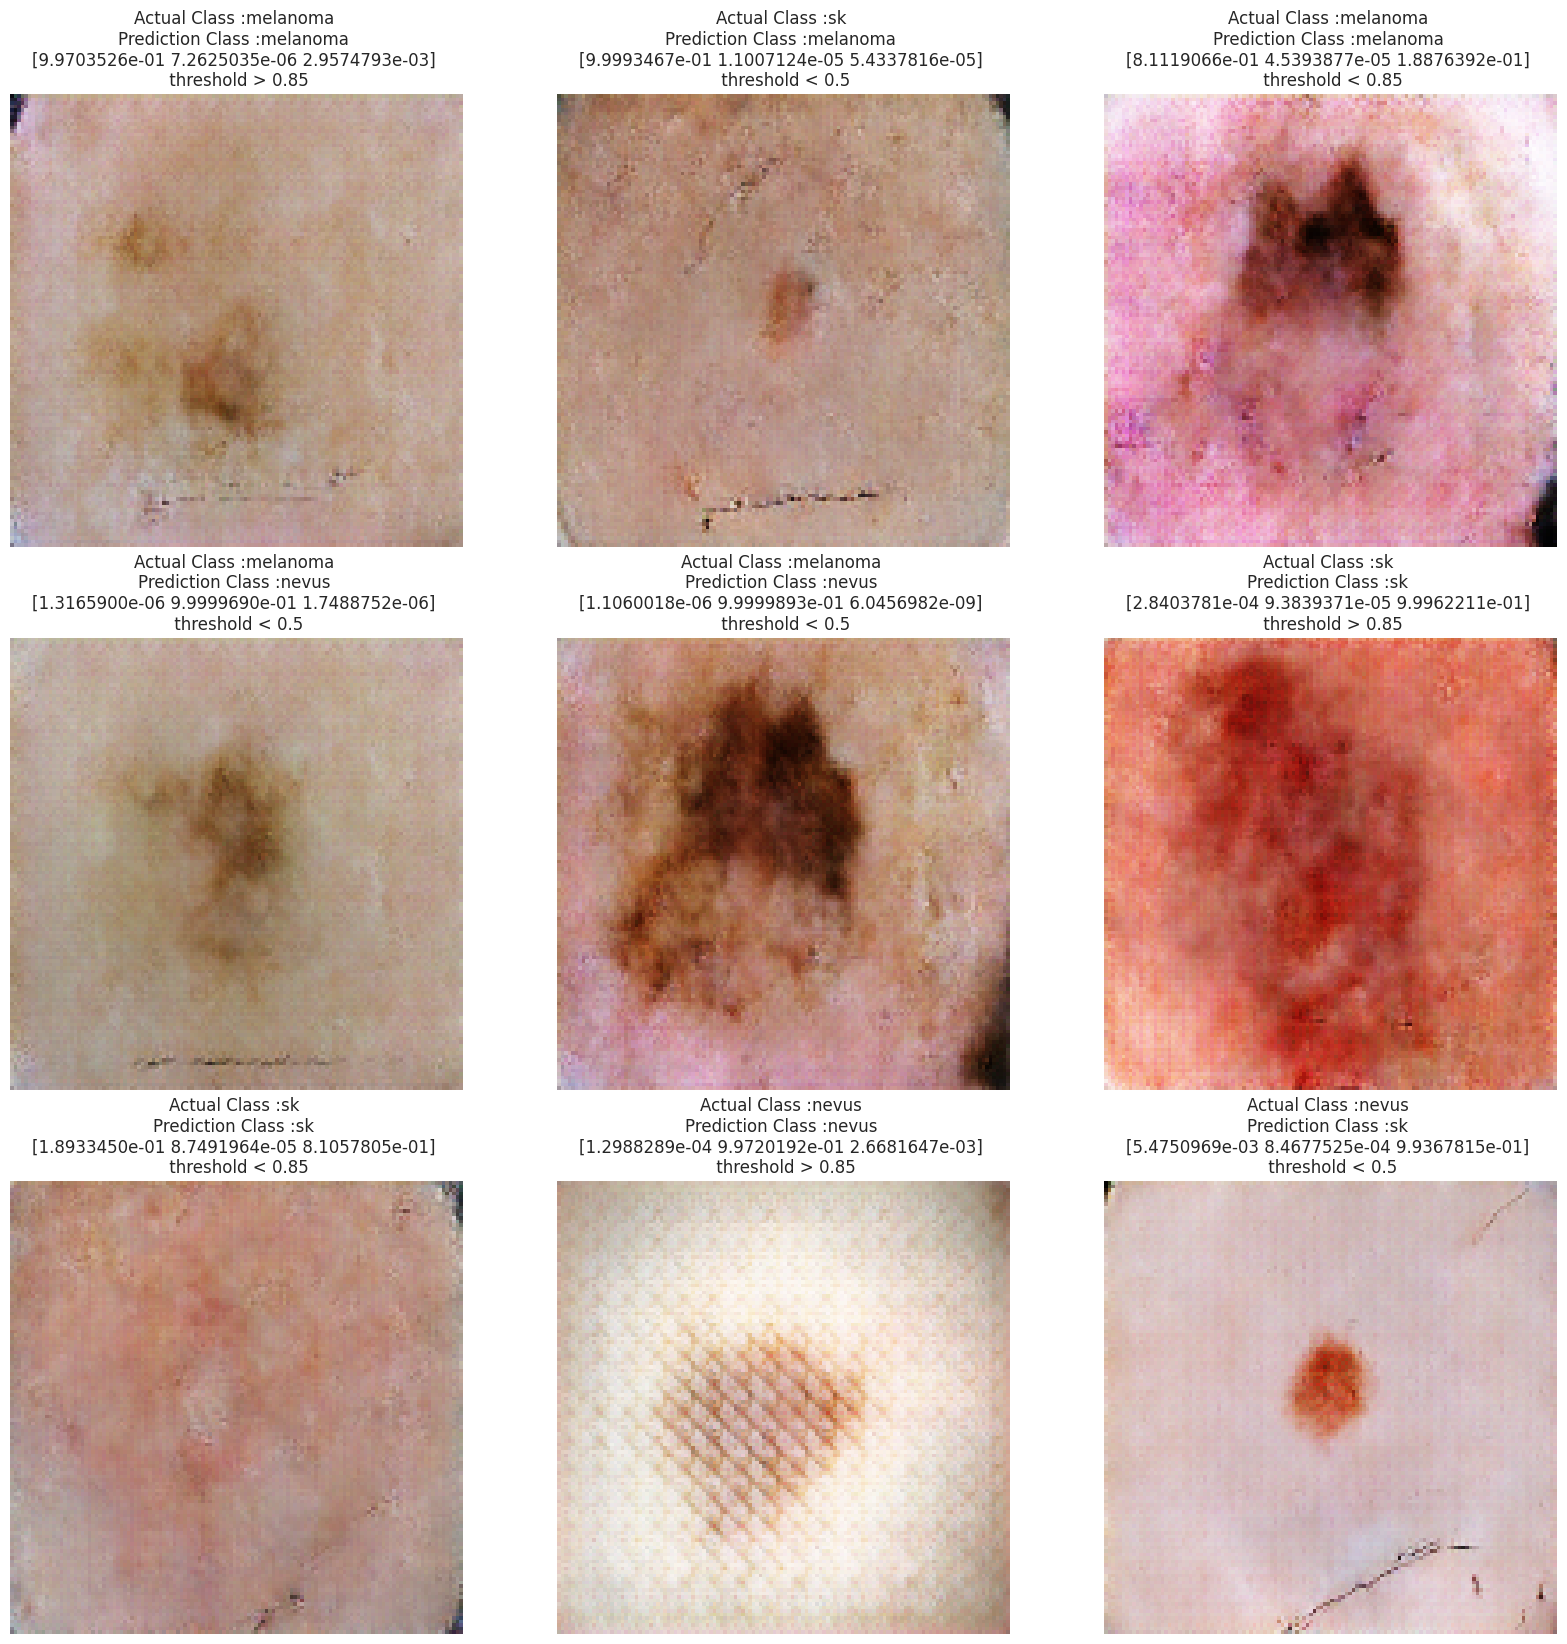

In [149]:
plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    if predictions[i][labels[i]] < 0.5:
        txt = "threshold < 0.5"
    elif predictions[i][labels[i]] >= 0.5 and predictions[i][labels[i]] < 0.75:
        txt = "threshold < 0.75"
    elif predictions[i][labels[i]] >= 0.75 and predictions[i][labels[i]] < 0.85:
        txt = "threshold < 0.85"
    else:
        txt = "threshold > 0.85"
    plt.title(f"Actual Class :{class_names[labels[i]]} \nPrediction Class :{class_names[result[i]]} \n{predictions[i]} \n {txt}")
    plt.axis("off")

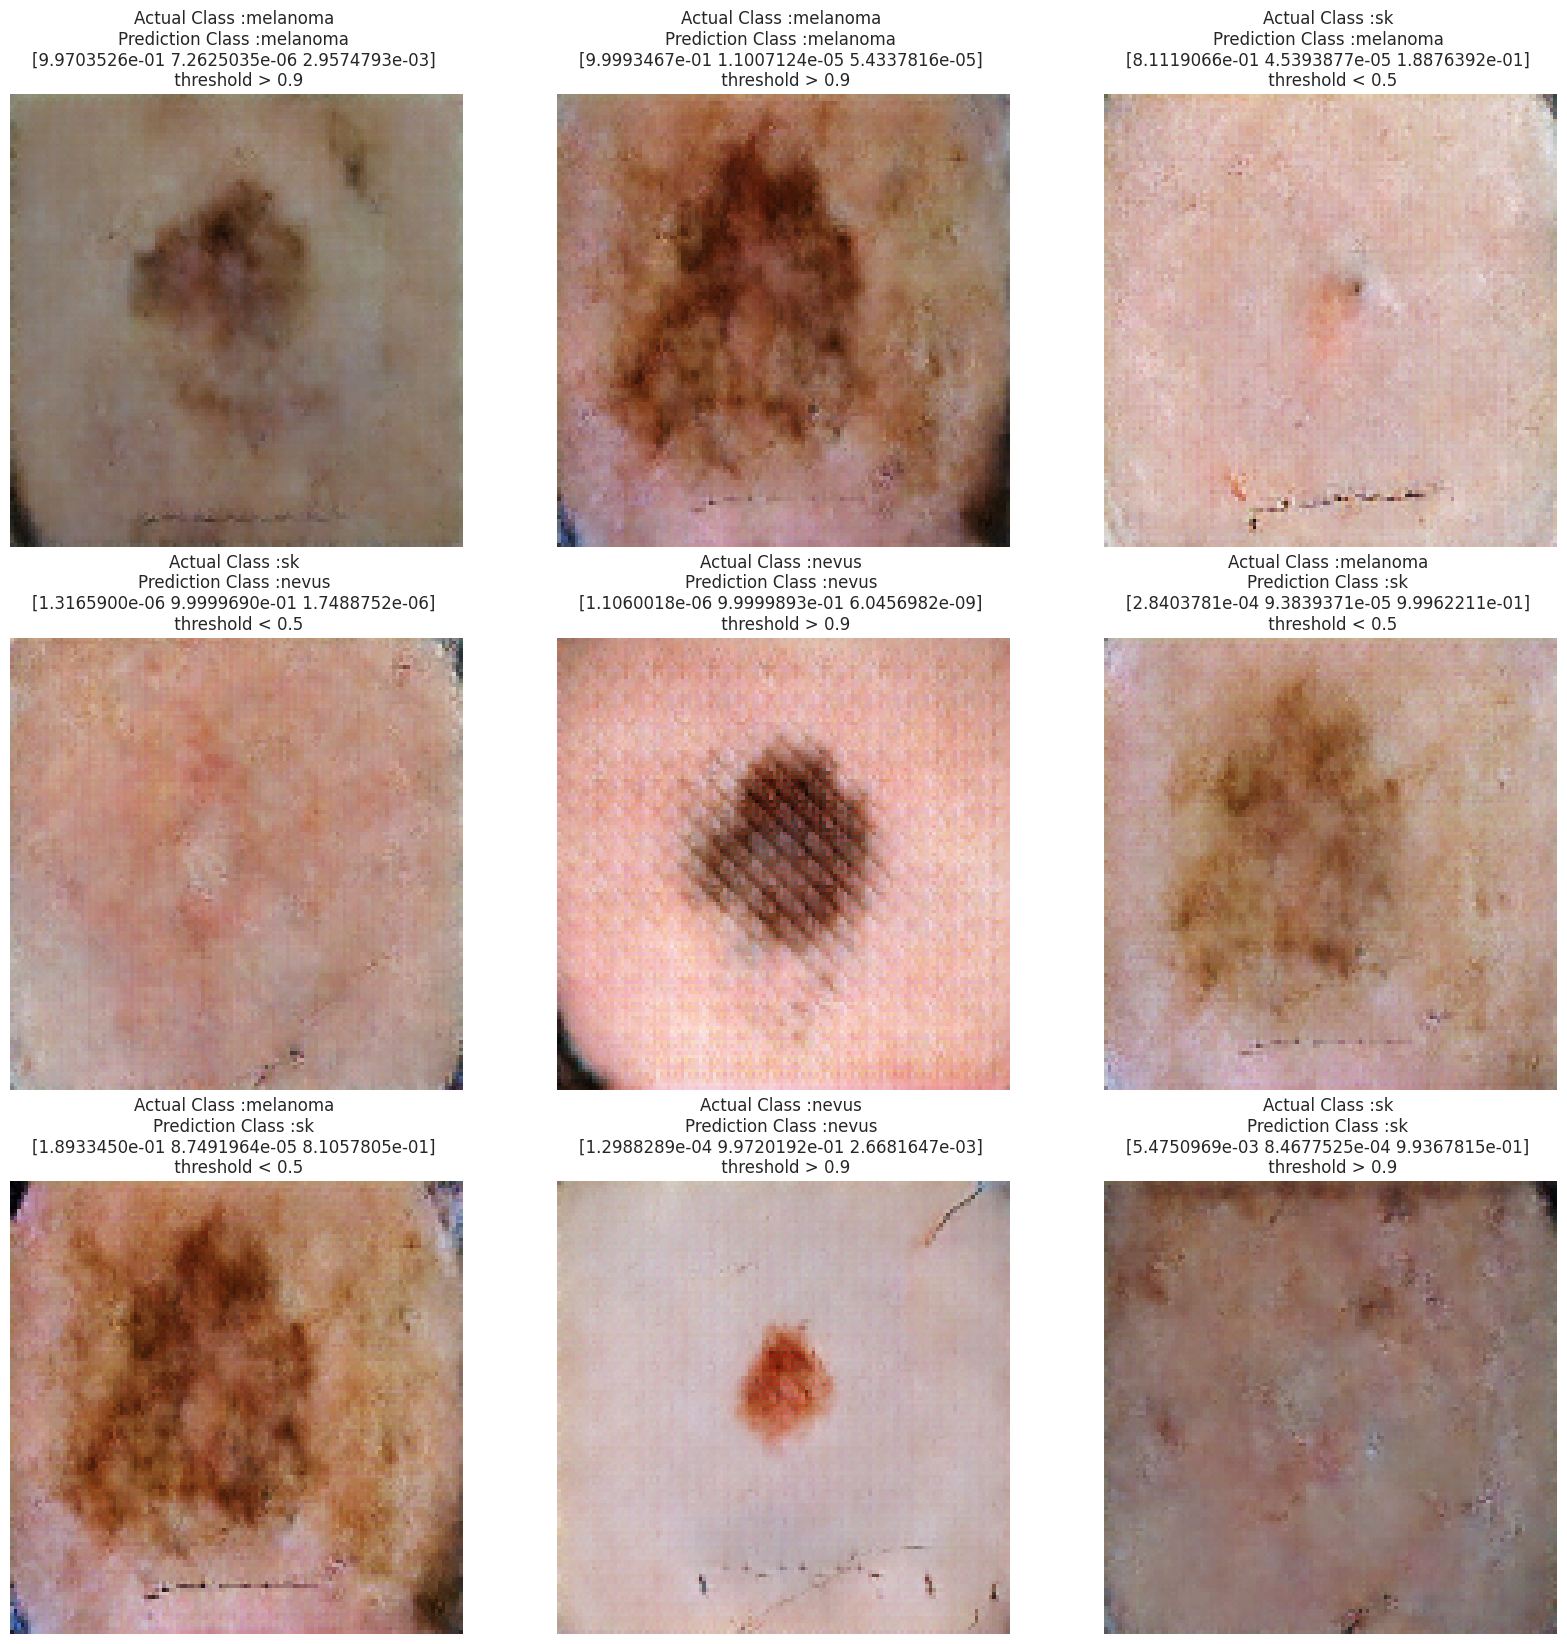

In [150]:
images,labels = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
result = predictions.argmax(axis=1)

plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    if predictions[i][labels[i]] < 0.5:
        txt = "threshold < 0.5"
    elif predictions[i][labels[i]] >= 0.5 and predictions[i][labels[i]] < 0.75:
        txt = "threshold < 0.75"
    elif predictions[i][labels[i]] >= 0.75 and predictions[i][labels[i]] < 0.85:
        txt = "threshold < 0.8"
    else:
        txt = "threshold > 0.9"
    plt.title(f"Actual Class :{class_names[labels[i]]} \nPrediction Class :{class_names[result[i]]} \n{predictions[i]} \n {txt}")
    plt.axis("off")

In [151]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 efficientnetb7 (Functional  (None, 4, 4, 2560)        64097687  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 2560)              0         
                                                                 
 flatten_2 (Flatten)         (None, 2560)              0   

In [152]:
from sklearn.manifold import TSNE

In [153]:
feature = model.layers[:-1]

In [154]:
model2 = tf.keras.Model(inputs=inputs, outputs=model.layers[-2].output)

In [155]:
model2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 efficientnetb7 (Functional  (None, 4, 4, 2560)        64097687  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 2560)              0         
                                                                 
 flatten_2 (Flatten)         (None, 2560)              0   

In [156]:
images,labels = train_dataset.as_numpy_iterator().next()
predictions = model2.predict_on_batch(image_batch)

In [157]:
predictions.shape

(32, 128)

In [158]:
tsne = TSNE(n_components=2).fit_transform(predictions)

In [159]:
tsne

array([[  4.487551 , -15.421477 ],
       [  4.612201 , -15.314125 ],
       [  4.404001 , -15.568561 ],
       [  5.2334876, -15.836674 ],
       [  5.3337007, -15.756953 ],
       [  4.520467 , -16.004665 ],
       [  4.4282136, -15.737878 ],
       [  5.0804405, -15.91823  ],
       [  4.5287743, -15.95403  ],
       [  4.3818827, -15.9401245],
       [  5.147316 , -15.498265 ],
       [  4.6336417, -15.330519 ],
       [  4.404928 , -15.45106  ],
       [  4.48251  , -15.970102 ],
       [  5.3184934, -15.674775 ],
       [  4.422941 , -15.406782 ],
       [  4.471807 , -15.845512 ],
       [  4.2516456, -15.806896 ],
       [  4.2390957, -15.488328 ],
       [  5.3520555, -15.639039 ],
       [  5.2283726, -15.761527 ],
       [  4.417428 , -16.020452 ],
       [  4.158435 , -15.887208 ],
       [  4.4711623, -15.295846 ],
       [  4.3909435, -15.263119 ],
       [  4.4457946, -15.31547  ],
       [  5.1739907, -15.927894 ],
       [  4.2570286, -15.907525 ],
       [  5.1888833,

In [160]:
import seaborn as sns

<Axes: >

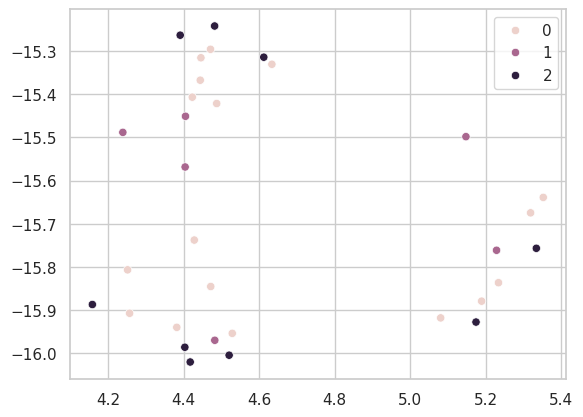

In [161]:
sns.scatterplot(x=tsne[:,0],y=tsne[:,1],hue=labels)

In [162]:
result_list = []
labels_list = []
for batch in test_dataset:
    images,labels = batch
    predictions = model2.predict_on_batch(images)
    result_list.append(predictions)
    labels_list.append(labels)

In [163]:
import numpy as np

plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [164]:
sns.set_theme(style="whitegrid")

In [165]:
result_arr = np.concatenate(result_list)
labels_arr = np.concatenate(labels_list)

In [174]:
tsne = TSNE(n_components=2,perplexity=150).fit_transform(result_arr)

Text(0.5, 1.0, 'Visualize Distribution ISIC 2017 after applied our method using t-SNE')

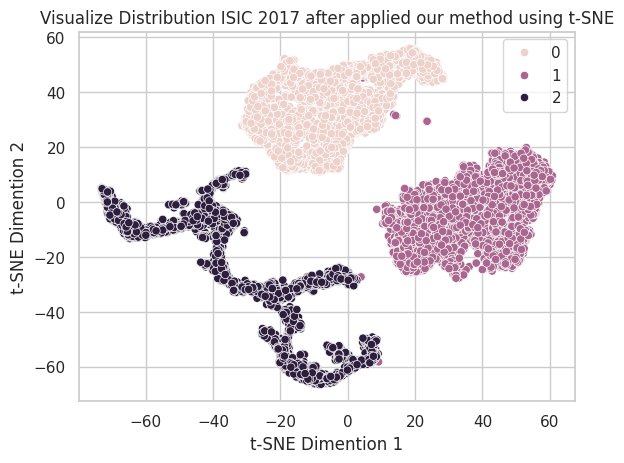

In [175]:
sns.scatterplot(x=tsne[:,0],y=tsne[:,1],hue=labels_arr)
plt.xlabel("t-SNE Dimention 1")
plt.ylabel("t-SNE Dimention 2")
plt.title("Visualize Distribution ISIC 2017 after applied our method using t-SNE")

Text(0.5, 1.0, 'Visualize Distribution ISIC 2017 after applied our method using t-SNE')

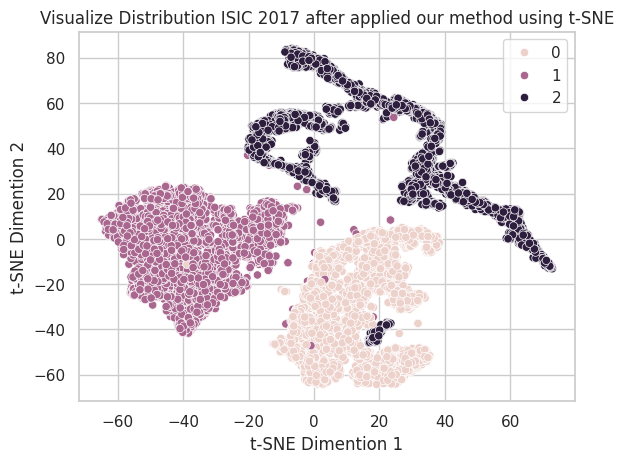

In [119]:
sns.scatterplot(x=tsne[:,0],y=tsne[:,1],hue=labels_arr)
plt.xlabel("t-SNE Dimention 1")
plt.ylabel("t-SNE Dimention 2")
plt.title("Visualize Distribution ISIC 2017 after applied our method using t-SNE")

In [431]:
def map_values(val):
    mapping = {0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratosis'}
    return mapping[val]
vfunc = np.vectorize(map_values)

In [432]:
transformed_arr = vfunc(labels_arr)

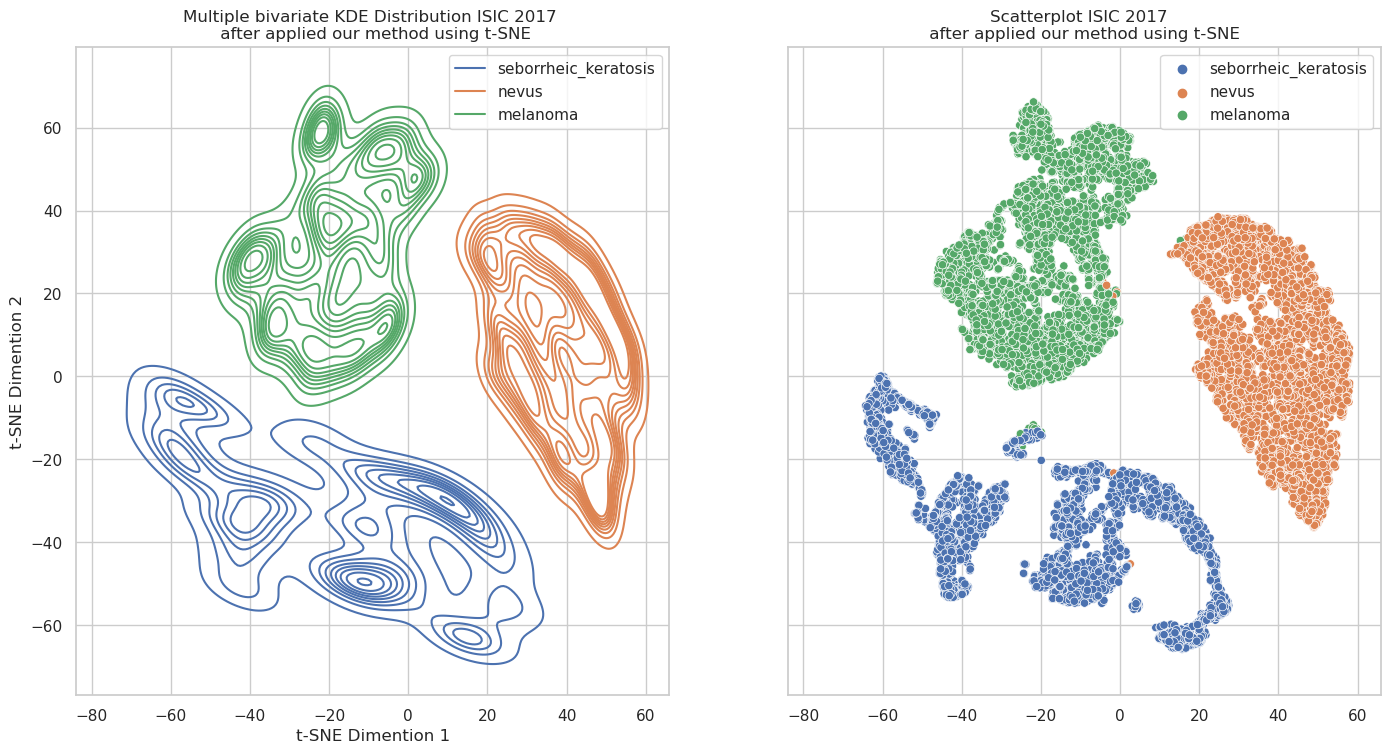

In [434]:
f, ax = plt.subplots(1,2,figsize=(15, 8),sharex=True,sharey=True)
ax[0].set_title("Multiple bivariate KDE Distribution ISIC 2017 \n after applied our method using t-SNE")
ax[1].set_title("Scatterplot ISIC 2017  \n after applied our method using t-SNE ")
# plt.title("Visualization ISIC-2017 using t-SNE")
ax[0].set_xlabel("t-SNE Dimention 1")
ax[0].set_ylabel("t-SNE Dimention 2");
sns.kdeplot(ax=ax[0],x=tsne[:,0],y=tsne[:,1],hue=transformed_arr)
sns.scatterplot(ax=ax[1],x=tsne[:,0],y=tsne[:,1],hue=transformed_arr);


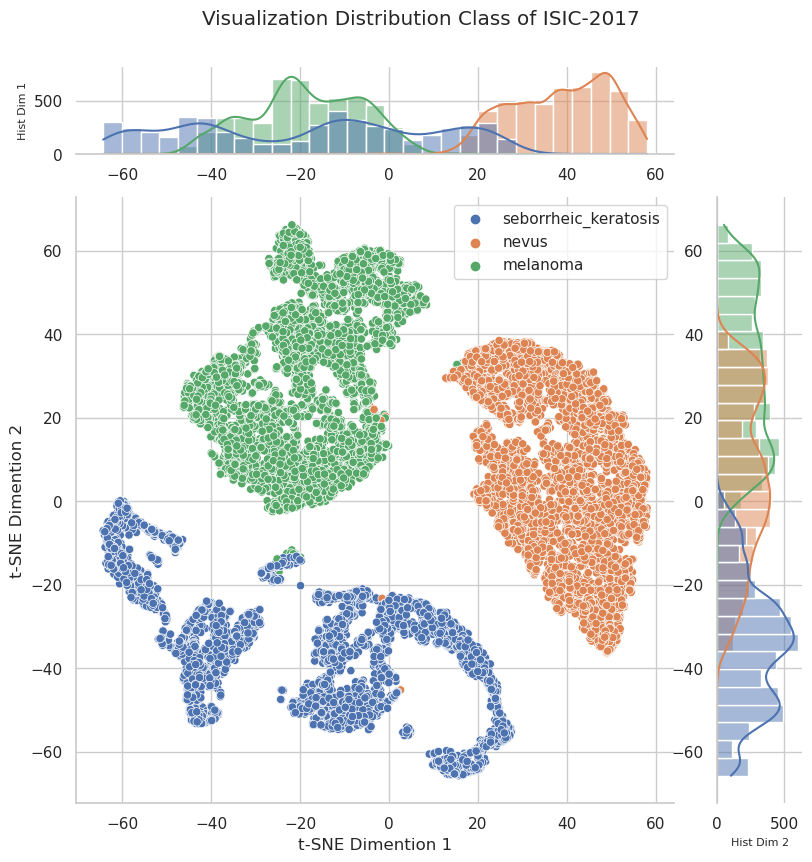

In [435]:
j = sns.jointplot(x=tsne[:,0],y=tsne[:,1],hue=transformed_arr,height=8,space=0.5)

j.ax_marg_x.cla()
j.ax_marg_y.cla()
j.fig.suptitle('Visualization Distribution Class of ISIC-2017', y=1.05)
j.ax_joint.set_xlabel("t-SNE Dimention 1")
j.ax_joint.set_ylabel("t-SNE Dimention 2")

ax = sns.histplot(x=tsne[:,0],hue=transformed_arr, ax=j.ax_marg_x,legend=False,kde=True)
ay = sns.histplot(y=tsne[:,1],hue=transformed_arr, ax=j.ax_marg_y,legend=False,kde=True)
ax.set_ylabel("Hist Dim 1",fontsize=8)
ay.set_xlabel("Hist Dim 2",fontsize=8);

# ax.set_xticks([])

In [28]:
import cv2
import glob
import numpy as np

In [66]:
eee = {">=80%":[],">=75%":[],">=65%":[],"<50%":[]}
for name in glob.glob("dataset/skin-lesions/test/*/*.jpg"):
    l = predict_image(model,name)
    print(l)
    if l[0][np.argmax(l)] >= 0.8:
        eee[">=80%"].append(name)
    elif l[0][np.argmax(l)] >= 0.75:
        eee[">=75%"].append(name)
    elif l[0][np.argmax(l)] >= 0.65:
        eee[">=65%"].append(name)
    else:
        eee["<50%"].append(name)
    # if class_names.index(name.split("/")[-2]) == np.argmax(l):
    #     print("same")
    #     if np.max(l) >= 0.8:
    #         eee[">=80%"].append(name)
    #     elif np.max(l) >= 0.75:
    #         eee[">=75%"].append(name)
    #     elif np.max(l) >= 0.65:
    #         eee[">=65%"].append(name)
    #     else:
    #         eee["<50%"].append(name)
    # else:
    #     print("diff")
    #     if l[0][class_names.index(name.split("/")[-2])] >= 0.8:
    #         eee[">=80%"].append(name)
    #     elif l[0][class_names.index(name.split("/")[-2])] >= 0.75:
    #         eee[">=75%"].append(name)
    #     elif l[0][class_names.index(name.split("/")[-2])] >= 0.65:
    #         eee[">=65%"].append(name)
    #     else:
    #         eee["<50%"].append(name)
    

1/1 [==============================] - 0s 47ms/step
[[5.505695e-05 9.903223e-01 9.622738e-03]]
1/1 [==============================] - 0s 66ms/step
[[5.553305e-05 9.903077e-01 9.636813e-03]]
1/1 [==============================] - 0s 63ms/step
[[5.5857108e-05 9.9032474e-01 9.6193766e-03]]
1/1 [==============================] - 0s 97ms/step
[[5.5425855e-05 9.9026138e-01 9.6831182e-03]]
1/1 [==============================] - 0s 72ms/step
[[5.6062509e-05 9.9031514e-01 9.6288370e-03]]
1/1 [==============================] - 0s 70ms/step
[[5.602539e-05 9.904469e-01 9.497057e-03]]
1/1 [==============================] - 0s 100ms/step
[[5.590362e-05 9.903831e-01 9.560945e-03]]
1/1 [==============================] - 0s 100ms/step
[[5.5777928e-05 9.9031866e-01 9.6256025e-03]]
1/1 [==============================] - 0s 73ms/step
[[5.5626006e-05 9.9034798e-01 9.5963925e-03]]
1/1 [==============================] - 0s 81ms/step
[[5.544769e-05 9.903832e-01 9.561289e-03]]
1/1 [============================

In [71]:
eee

{'>=80%': ['dataset/skin-lesions/test/melanoma/ISIC_0012258.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0012356.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0012369.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0012395.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0012425.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0012758.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0012989.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0013072.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0013073.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0013242.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0013277.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0013321.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0013374.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0013411.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0013414.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0013455.jpg',
  'dataset/skin-lesions/test/melanoma/ISIC_0013459.jpg',
  'dataset/skin-lesion

In [67]:
result_list = []
labels_list = []
for img in eee[">=80%"]:
    l = predict_image(model2,img)
    result_list.append(l)
    labels_list.append(img.split("/")[-2])

1/1 [==============================] - 0s 52ms/step


In [68]:
result_arr = np.concatenate(result_list)
labels_arr = np.array(labels_list)

In [69]:
tsne = TSNE(n_components=2,perplexity=100).fit_transform(result_arr)

/home/isack/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/isack/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Distribution Data th < 50%')

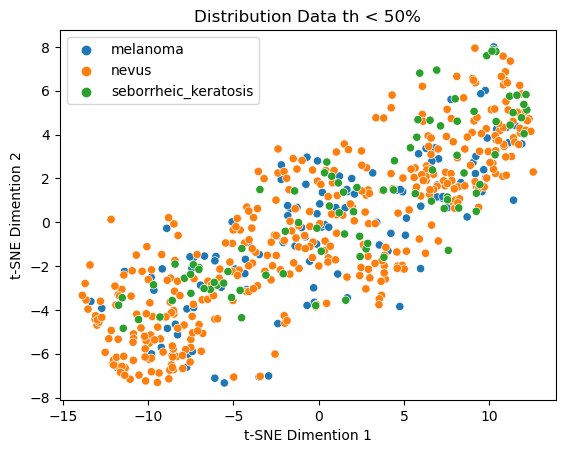

In [72]:
import seaborn as sns
sns.scatterplot(x=tsne[:,0],y=tsne[:,1],hue=labels_arr)
plt.xlabel("t-SNE Dimention 1")
plt.ylabel("t-SNE Dimention 2")
plt.title("Distribution Data th < 50%")